## Split original datasets into train and test

each image is RGB, 64 by 64.
Training datasets:
1. ISIC 
2. ISIC + DiDI
3. ISIC + ArGI

Testing Dataset:
ISIC + DiDI
Exclude ArGI because these images are not guaranteed to be real

80% of ISIC will be used in training
80% of DiDI will be used in training
80% of ArGI will be used in training
20% of ISIC will go to testing
20% of DiDI will go to testing

Data Sources:
ISIC: N = 1972
DiDI: N = 656
ArGI: N = 656

80/20 train/test split

In [2]:
import os
CWD = os.getcwd()
import numpy as np
import pandas as pd 
import shutil
import PIL
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import image
from tensorflow.image import ResizeMethod
import derm_ita as dita
import h5py

2024-05-28 23:47:05.285994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 23:47:05.286032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 23:47:05.287012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 23:47:05.292732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(CWD)

# output path
NEW = CWD + "/newdatasets"
print(NEW)

# Path for abbrev: ISIC
ISIC = CWD + "/datasets/ISIC"
print(ISIC)

# Path for abbrev: DiDI
DIDI = CWD + "/datasets/DiDI"
print(DIDI)

# Path for abbrev: AGI
ARGI = CWD + "/datasets/ArGI"
print(ARGI)

/mnt/e/AP Research/Capstone-Research-Project
/mnt/e/AP Research/Capstone-Research-Project/newdatasets
/mnt/e/AP Research/Capstone-Research-Project/datasets/ISIC
/mnt/e/AP Research/Capstone-Research-Project/datasets/DiDI
/mnt/e/AP Research/Capstone-Research-Project/datasets/ArGI


Processing
Create function to store the right images

1. Create ISIC_Train and ISIC_Test
2. Export ISIC_Train to .h5
3. Create DiDI_Train and DiDI_Test
4. Combine ISIC_Train and DiDI_Train
5. Export ISIC_DiDI_Train
6. Combine ISIC_Test and DiDI_Test
7. Export ISIC_DiDI_Test
8. Create ArGI_Train
9. Combine ISIC_Train and ArGI_Train
10. Export ISIC_ArGI_Train

Output .h5 files only contain two cols: images and labels

In [4]:
import random
def split(images, labels):
    n = len(images)
    n_test = round(0.2*n)
    n_train = round(0.8*n)
    if not (n_train == n - n_test):
        return ValueError
    
    test_idx, train_idx = 0,0
    test = np.empty(shape=[n_test, 64, 64, 3], dtype=np.uint8)
    train = np.empty(shape=[n_train, 64, 64, 3], dtype=np.uint8)
    test_labels = np.empty(shape=[n_test, 1])
    train_labels = np.empty(shape=[n_train ,1])
    
    test_indices = random.sample(range(n),n_test)
    for i in range(n):
        if i in test_indices:
            test[test_idx] = images[i]
            test_labels[test_idx] = labels[i]
            test_idx += 1
        else:
            train[train_idx] = images[i]
            train_labels[train_idx] = labels[i]
            train_idx += 1
        
    if not (len(test) == len(test_labels) == n_test):
        return ValueError

    if not (len(train) == len(train_labels) == n_train):
        return ValueError
    
    return train, train_labels, test, test_labels

In [5]:
def load(dataset, abbrev):
    metadata = pd.read_excel(f'{dataset}/metadata_{abbrev}.xlsx', index_col = 'index')
    num_imgs = len(metadata['id'])
    labels = np.array(metadata['malignance'], dtype=np.uint8).reshape(num_imgs, 1)
    images = np.empty(shape=[num_imgs, 64, 64, 3], dtype=np.uint8)
    for i in range(num_imgs):
        id = metadata['id'][i]
        #image = tf.keras.utils.load_img(f'{dataset}/all_images/{id}', target_size = (64, 64))
        #image =- cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image = cv2.imread(f'{dataset}/all_images/{id}')
        image = cv2.resize(image, (64, 64))
        images[i] = image
    
    if not (len(images) == len(labels) == num_imgs):
        return ValueError
    
    return images, labels

In [6]:
images_ISIC, labels_ISIC = load(ISIC, "ISIC")
train_ISIC, train_labels_ISIC, test_ISIC, test_labels_ISIC = split(images_ISIC, labels_ISIC)
print(len(train_ISIC))
print(len(train_labels_ISIC))
print(len(test_ISIC))
print(len(test_labels_ISIC))

1581
1581
395
395


In [7]:
images_DIDI, labels_DIDI = load(DIDI, "DiDI")
train_DIDI, train_labels_DIDI, test_DIDI, test_labels_DIDI = split(images_DIDI, labels_DIDI)
print(len(train_DIDI))
print(len(train_labels_DIDI))
print(len(test_DIDI))
print(len(test_labels_DIDI))

525
525
131
131


In [8]:
"""
take the label from the original ISIC content image
each ISIC id is formatted as ISIC_###### (ISIC_ followed by six digits. That's 11 total characters, so we'll take the initial substring)
of the ArGI image's name

We'll find the corresponding index of that ISIC_id in the ISIC labels array
then make the corresponding label for the ArGI image equal to that ISIC label.
"""

ids_ARGI = os.listdir(f'{ARGI}/all_images')
print(len(ids_ARGI))
n_ArGI = len(ids_ARGI)

metadata = pd.read_excel(f'{ISIC}/metadata_ISIC.xlsx', index_col = 'index')
ids_ISIC = metadata['id']

# Load ArGI images
images_ArGI = np.empty(shape=[n_ArGI, 64, 64, 3], dtype=np.uint8)
labels_ArGI = np.empty(shape=[n_ArGI, 1])
for i in range(n_ArGI):
    #image = tf.keras.utils.load_img(f'{CWD}/datasets/ArGI/all_images/{ids_ARGI[i]}', target_size = (64, 64))
    image = cv2.imread(f'{CWD}/datasets/ArGI/all_images/{ids_ARGI[i]}')
    image = cv2.resize(image, (64, 64))
    # find corresponding label
    for j in range(len(ids_ISIC)):
        if ids_ARGI[i][0:11] == ids_ISIC[j]:
            labels_ArGI[i] = labels_ISIC[j]

    #image =- cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images_ArGI[i] = image
print(len(images_ArGI))
print(len(labels_ArGI))

1150
1150
1150


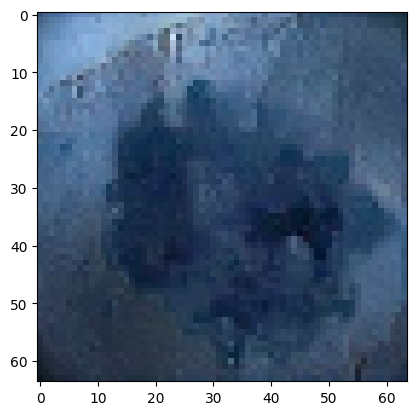

In [9]:
import matplotlib.pyplot as plt
plt.imshow(images_ArGI[0])

In [10]:
print(images_ArGI.shape)

(1150, 64, 64, 3)


In [11]:
# Custom split for ArGI; we're not going to return a test set and we're only going to go for 525, the length of train_DiDI
def split_ArGI(images, labels):
    n = len(images)
    n_train = 525
    n_test = n - 525
    
    if not (n_train == n - n_test):
        return ValueError
    
    train_idx = 0
    train = np.empty(shape=[n_train, 64, 64, 3], dtype=np.uint8)
    train_labels = np.empty(shape=[n_train])
    
    test_indices = random.sample(range(n),n_test)

    for i in range(n):
        if i in test_indices:
            continue
        else:
            train[train_idx] = images[i]
            train_labels[train_idx] = labels[i]
            train_idx += 1

    if not (len(train) == len(train_labels) == n_train):
        return ValueError
    
    return train, train_labels

In [12]:
train_ArGI, train_labels_ArGI = split_ArGI(images_ArGI, labels_ArGI)
print(len(train_ArGI))
print(len(train_labels_ArGI))

525
525


/tmp/ipykernel_26747/428344164.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels[train_idx] = labels[i]


In [13]:
def export(images, labels, filename):
    with h5py.File(f'{CWD}/{filename}.h5','w') as f:
        f.create_dataset('images', data = images)
        f.create_dataset('labels', data = labels)


# """ Execute on Exports
# Processing
# Create function to store the right images

# 1. Create ISIC_Train and ISIC_Test
# 2. Export ISIC_Train to .h5
# 3. Create DiDI_Train and DiDI_Test
# 4. Combine ISIC_Train and DiDI_Train
# 5. Export ISIC_DiDI_Train
# 6. Combine ISIC_Test and DiDI_Test
# 7. Export ISIC_DiDI_Test
# 8. Create ArGI_Train
# 9. Combine ISIC_Train and ArGI_Train
# 10. Export ISIC_ArGI_Train

# Output .h5 files only contain two cols: images and labels
# """

In [14]:
print(NEW)

/mnt/e/AP Research/Capstone-Research-Project/newdatasets


In [15]:
# Merging to create compound datasets

train_ISIC_DiDI = np.append(train_ISIC, train_DIDI, axis=0)
train_labels_ISIC_DiDI = np.append(train_labels_ISIC, train_labels_DIDI)
train_labels_ISIC_DiDI = np.reshape(train_labels_ISIC_DiDI, [len(train_ISIC_DiDI), 1])
if len(train_ISIC_DiDI) == len(train_labels_ISIC_DiDI):
    print(len(train_ISIC_DiDI)) 
    print(train_labels_ISIC_DiDI.shape)

test_ISIC_DiDI = np.append(test_ISIC, test_DIDI, axis=0)
test_labels_ISIC_DiDI = np.append(test_labels_ISIC, test_labels_DIDI)
test_labels_ISIC_DiDI = np.reshape(test_labels_ISIC_DiDI, [len(test_ISIC_DiDI), 1])
if len(test_ISIC_DiDI) == len(test_labels_ISIC_DiDI):
    print(len(test_ISIC_DiDI)) 
    print(test_labels_ISIC_DiDI.shape)

train_ISIC_ArGI = np.append(train_ISIC, train_ArGI, axis=0)
train_labels_ISIC_ArGI = np.append(train_labels_ISIC, train_labels_ArGI)
train_labels_ISIC_ArGI = np.reshape(train_labels_ISIC_ArGI, [len(train_ISIC_ArGI), 1])
if len(train_ISIC_ArGI) == len(train_labels_ISIC_ArGI):
    print(len(train_ISIC_ArGI)) 
    print(train_labels_ISIC_ArGI.shape)

2106
(2106, 1)
526
(526, 1)
2106
(2106, 1)


In [16]:
export(train_ISIC, train_labels_ISIC, 'train_ISIC')
export(train_ISIC_DiDI, train_labels_ISIC_DiDI, 'train_ISIC_DiDI')
export(train_ISIC_ArGI, train_labels_ISIC_ArGI, 'train_ISIC_ArGI')
export(test_ISIC_DiDI, test_labels_ISIC_DiDI, 'test_ISIC_DiDI')